In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import comet_ml in the top of your file
from comet_ml import Experiment

# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="mri-epilepsy-classification", workspace="kondratevakate")
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

/gpfs/data/opt/python-3.6.8/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/mri-epilepsy-classification/a89d0b791259479e8f1bd11a8c7ac2c3



In [3]:
!nvidia-smi

Fri May 22 19:37:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   40C    P8    10W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [5]:
import sys
sys.path.append("../..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
# from utils import routine

### 0. Dataset

In [6]:
soloviev_data = MriClassification(sample='soloviev', data_type = 'img', ignore_missing=True,
                                  targets_path ='../../targets/targets_fcd_bank.csv',
                                  coord_min=(35,35,35), img_shape=(180,180,180))

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:11<00:00, 15.33it/s]


In [7]:
soloviev_data.scan_keys

array(['1.5T_soloviev'], dtype=object)

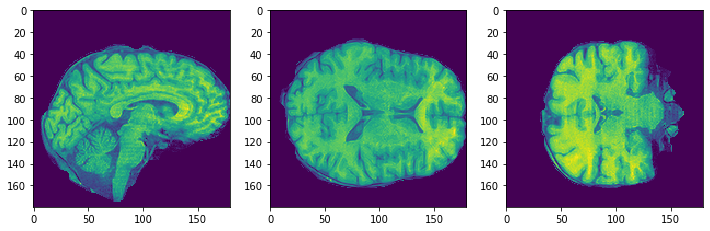

In [8]:
img, target, scan = soloviev_data[0]
plot_central_cuts(img)

In [9]:
soloviev_data.target.value_counts()

1    91
0    90
Name: fcd, dtype: int64

### 1. Classification w/o data normalisation


In [10]:
import sys
sys.path.append("../")
from models.cnn_model import CNN

experiment.set_name("VoxCNN, baseline cv")

In [11]:
torch.cuda.empty_cache()

In [53]:
%%time
from routine import *
model_params = {
    "n_filters": 32,
    "stride": 2,
    "n_blocks": 4,
    "input_shape": (180,180,180),
    "n_fc_units": 180
}
train_dataset = soloviev_data
model_cnn = CNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_cnn)

batch_size = 12

split_ = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_idx = list(split_.split(X=np.arange(len(train_dataset)), y=train_dataset.target))[0]
train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

val_loader = DataLoader(Subset(train_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)

CPU times: user 76.3 ms, sys: 448 µs, total: 76.8 ms
Wall time: 75.5 ms


### 2. Train one epoch to finetune the model

Epoch 20 of 20 took 27.664s
  training loss (in-iteration): 	4.642579
  validation loss: 			5.410257
  training roc_auc_score: 			0.88
  validation roc_auc_score: 			0.54


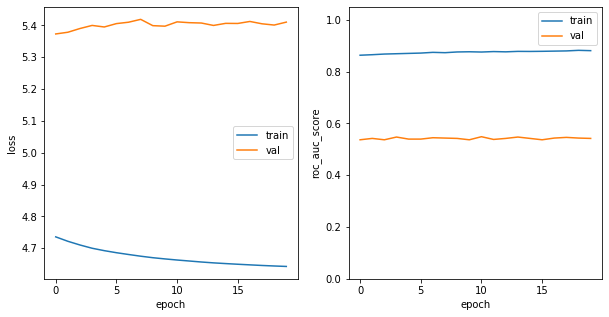

<Figure size 720x360 with 0 Axes>

In [60]:
training_params = {
    "model": model_cnn,
    "optimizer": optimizer,
    "scheduler": scheduler,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader,
    "device": device,
    "metric": roc_auc_score,
    "eps": 1e-2,
    "experiment": experiment,
    "max_epoch": 20,
    "verbose": 1,
}

last_train_loss, last_train_metric, last_val_loss, last_val_metric = train(**training_params)

In [61]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kondratevakate/mri-epilepsy-classification/a89d0b791259479e8f1bd11a8c7ac2c3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [31]            : (4.582772731781006, 5.4561991691589355)
COMET INFO:     mean_train_loss [26] : (4.642578601837158, 5.361763000488281)
COMET INFO:     mean_val_loss [26]   : (4.675400733947754, 6.8010711669921875)
COMET INFO:     train_loss [309]     : (array(4.5661244, dtype=float32), array(5.53849, dtype=float32))
COMET INFO:     train_metric [26]    : (0.5715663580246912, 0.8825900730662635)
COMET INFO:     val_loss [128]       : (array(4.4267507, dtype=float32), array(6.8096924, dtype=float32))
COMET INFO:     val_metric [26]      : (0.40350877192982454, 0.6349206349206349)
COMET INFO:   Others:
COMET INFO

### 3. Cross-validate on the best performing model

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score

cv_params = {
    "cnn_model": model_cnn,
    "batch_size": 12,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": roc_auc_score,
    "experiment": experiment,
    "max_epoch": 10,
}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))